# Telco Churn Prediction - Preprocessing Pipeline

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

In [2]:
# Load Raw Dataset
df = pd.read_csv("data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")

Data Cleaning & Encoding - Handled by Herath D.H.M.P.C - IT24102356

Handling Missing Values

In [3]:
# Dataset info
print(df.shape)
print(df.info())
df.head()

(7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Check null values
print(df.isnull().sum())

# Special check: blank strings in TotalCharges
blank_totalcharges = (df['TotalCharges'].str.strip() == "").sum()
print("Blank TotalCharges:", blank_totalcharges)

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
Blank TotalCharges: 11


In [5]:
# Convert TotalCharges to numeric, forcing blanks to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Recheck missing count
print(df['TotalCharges'].isnull().sum())

11


In [ ]:
# Fill with 0 if tenure = 0
df.loc[df['tenure'] == 0, 'TotalCharges'] = 0

# Group median imputation for others
df['TotalCharges'] = df.groupby('Contract')['TotalCharges'].transform(
    lambda x: x.fillna(x.median())
)

# Missing values after imputation 
print(df['TotalCharges'].isnull().sum())

0


Encoding Categorical Variables

In [7]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

In [8]:
df.drop('customerID', axis=1, inplace=True)

In [9]:
# Separate categorical and numeric columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_cols)

Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


In [10]:
# Label encoding for binary variables
binary_cols = [
    'gender', 'Partner', 'Dependents', 'PhoneService',
    'PaperlessBilling', 'Churn'
]

le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

In [11]:
# Ordinal Encoding
contract_order = [['Month-to-month', 'One year', 'Two year']]
encoder = OrdinalEncoder(categories=contract_order)
df['Contract'] = encoder.fit_transform(df[['Contract']])

In [12]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['InternetService','PaymentMethod','MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies'])

Outlier Detection and Removal - Handled by Abhimani N.H.A - IT24102390

In [13]:
# Select numeric columns
num_cols = ['tenure','MonthlyCharges','TotalCharges']
df[num_cols].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


In [14]:
# Detect Outliers (IQR method)
def find_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series[(series < lower) | (series > upper)]

outliers_mc = find_outliers_iqr(df['MonthlyCharges'])
outliers_tc = find_outliers_iqr(df['TotalCharges'])

print("MonthlyCharges outliers:", len(outliers_mc))
print("TotalCharges outliers:", len(outliers_tc))

MonthlyCharges outliers: 0
TotalCharges outliers: 0


In [15]:
# Cap outliers
df_no_outliers = df.copy()

Q1 = df['MonthlyCharges'].quantile(0.25)
Q3 = df['MonthlyCharges'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

df_no_outliers['MonthlyCharges'] = df_no_outliers['MonthlyCharges'].clip(lower, upper)

Normalization and Scaling - Handled by Pamithu Dulwan H.G - IT24102399

In [16]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [17]:
# Select numerical columns
num_cols = ['tenure','MonthlyCharges','TotalCharges']
df[num_cols].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


In [18]:
# Standard scaling
scaler_std = StandardScaler()
df_std = df.copy()
df_std[num_cols] = scaler_std.fit_transform(df[num_cols])

Feature Engineering - Handled by Jayawickrama I.N - IT24102333

In [19]:
# New Feature 1: Services Count
yes_cols = [col for col in df.columns if col.endswith('_Yes') and any(s in col for s in ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies'])]

df['services_count'] = df[yes_cols].sum(axis=1)

In [20]:
# New Feature 2: Tenure Group (pure numeric)
df['tenure_group'] = pd.cut(df['tenure'],
                            bins=[-1, 6, 12, 24, 48, 72],
                            labels=False)

In [21]:
# New Feature 3: Average Charge Per Month
df['avg_charge_per_month'] = df['TotalCharges'] / (df['tenure'].replace(0,1))

Feature Selection - Handled by Janathunarachchi J.A.Y.V. - IT24102381

In [22]:
# Separate features and target
X = df.drop("Churn", axis=1)
y = df["Churn"]

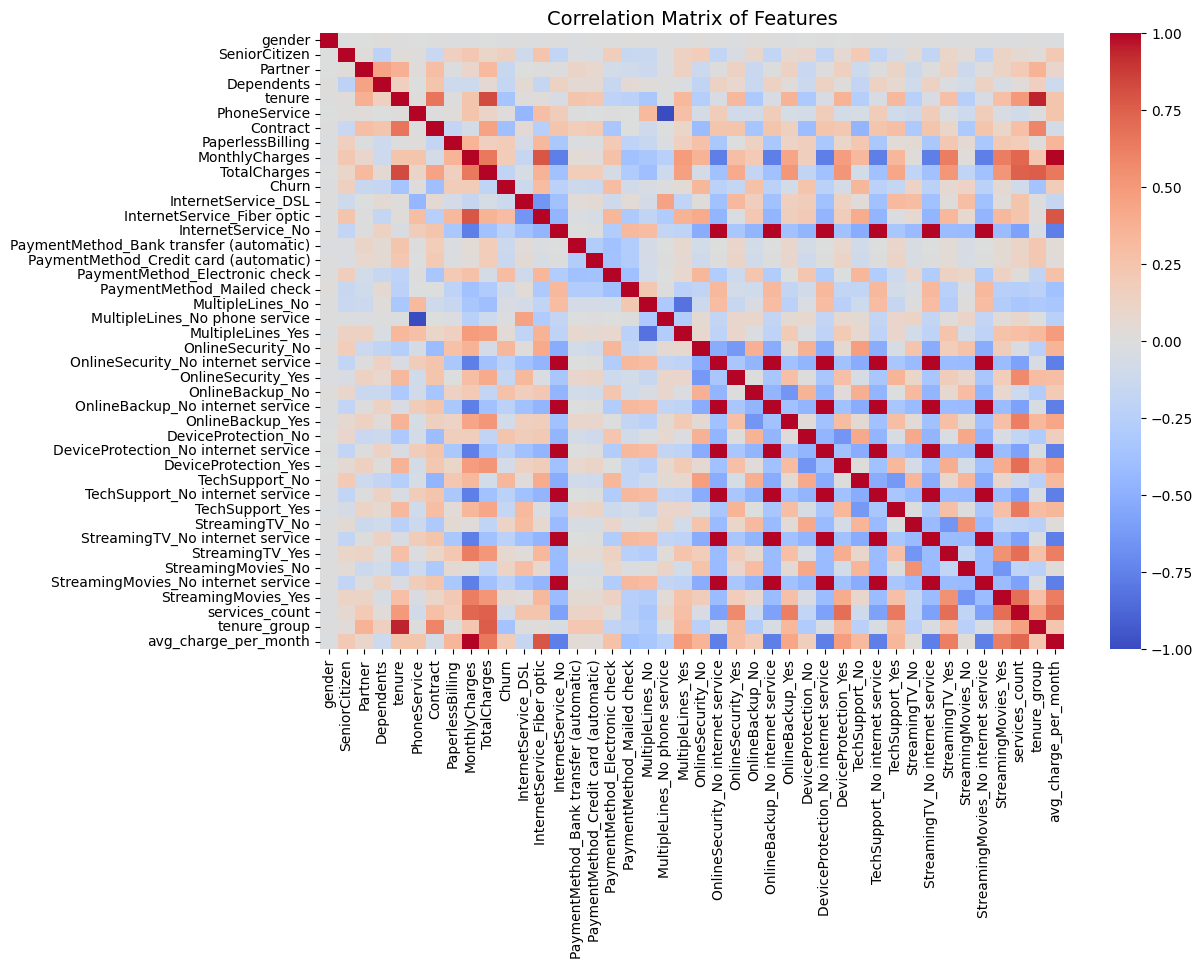

In [23]:
# EDA - Correlation Matrix
plt.figure(figsize=(12,8))
corr = df.corr(numeric_only=True)  # Only numeric/bool
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Features", fontsize=14)
plt.show()

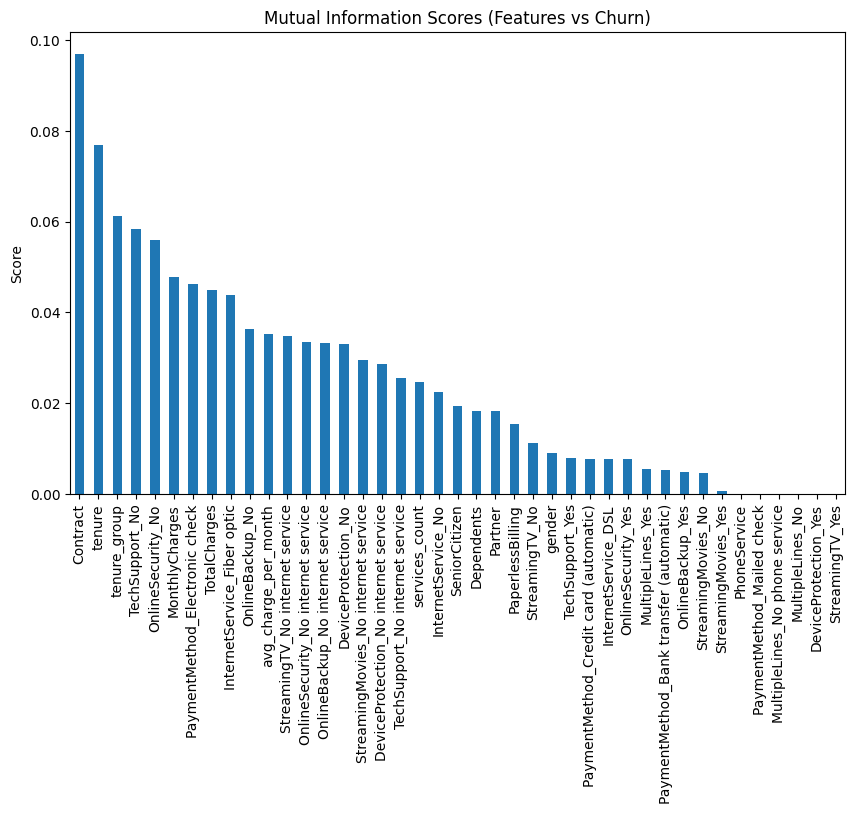

In [24]:
# Statistical Feature Importance - Mutual Information
mi_scores = mutual_info_classif(X, y, random_state=42)

mi_results = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
mi_results.plot(kind="bar")
plt.title("Mutual Information Scores (Features vs Churn)")
plt.ylabel("Score")
plt.show()

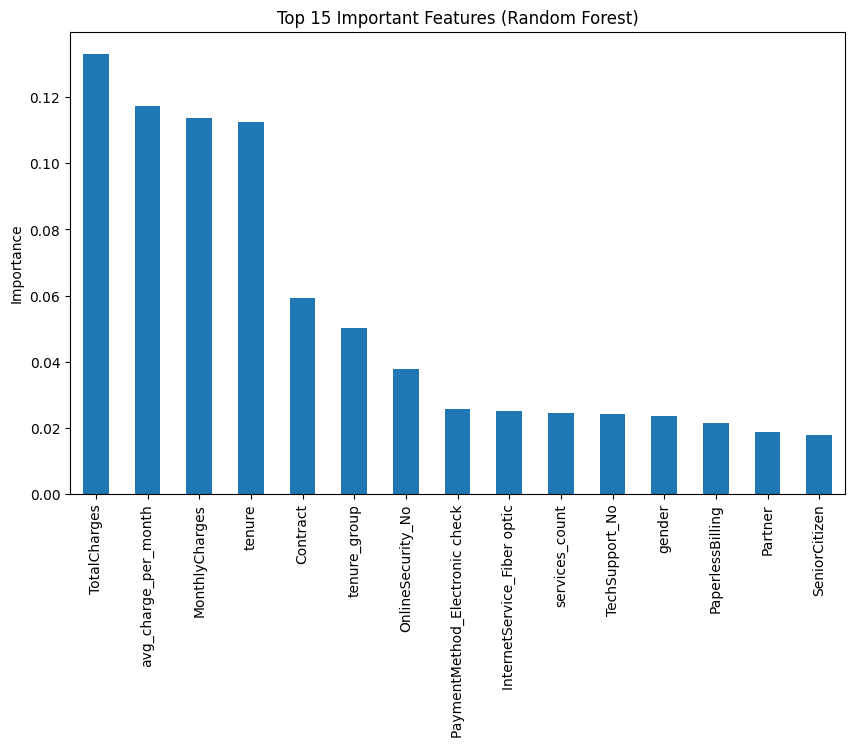

In [ ]:
# Model-based Feature Selection (Random Forest)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))

importances.head(15).plot(kind="bar")
plt.title("Top 15 Important Features (Random Forest)")
plt.ylabel("Importance")
plt.show()

In [26]:
# Select features above mean importance
selector = SelectFromModel(rf, threshold="mean", prefit=True)
selected_features = X.columns[selector.get_support()]

print("Selected Features:\n", selected_features.tolist())

Selected Features:
 ['tenure', 'Contract', 'MonthlyCharges', 'TotalCharges', 'InternetService_Fiber optic', 'PaymentMethod_Electronic check', 'OnlineSecurity_No', 'services_count', 'tenure_group', 'avg_charge_per_month']


In [27]:
# Final Reduced Dataset
X_selected = X[selected_features]
print("Shape before feature selection:", X.shape)
print("Shape after feature selection:", X_selected.shape)

Shape before feature selection: (7043, 41)
Shape after feature selection: (7043, 10)


Dimensionality Reduction - Handled by Nethmuthu R. A. H. - IT24102421

In [28]:
df = X_selected
y = pd.read_csv("results/outputs/feature_engineered_telco_data.csv")["Churn"]  # keep target variable

In [29]:
# Standardize the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

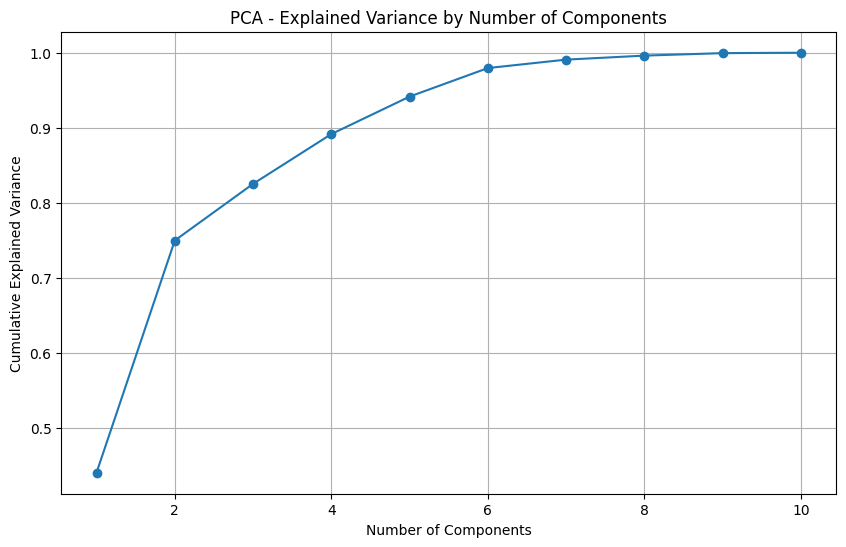

In [30]:
# PCA - Variance Explained
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_var = pca.explained_variance_ratio_

plt.figure(figsize=(10,6))
plt.plot(range(1, len(explained_var)+1), explained_var.cumsum(), marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Explained Variance by Number of Components")
plt.grid(True)
plt.show()

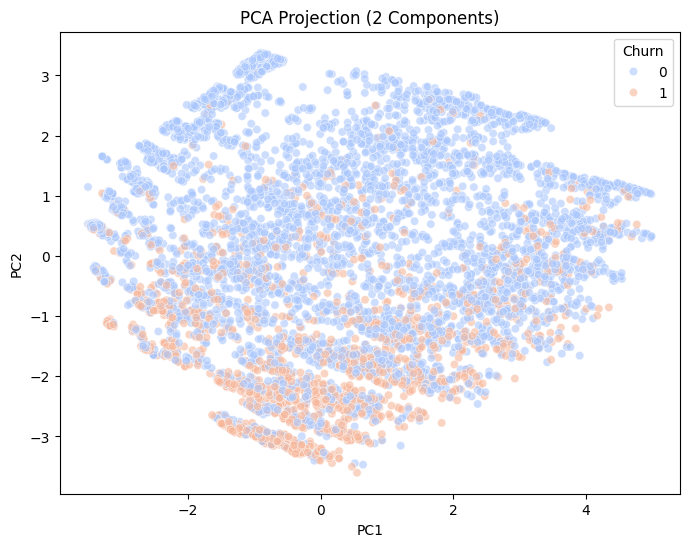

In [31]:
# PCA - 2D Visualization
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca2[:,0], y=X_pca2[:,1], hue=y, palette="coolwarm", alpha=0.6)
plt.title("PCA Projection (2 Components)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Churn")
plt.show()

In [32]:
# Final Reduced Dataset (PCA with optimal components)
# Keeping enough components to explain ~90% variance
pca_final = PCA(n_components=10)
X_reduced = pca_final.fit_transform(X_scaled)

print("Original shape:", df.shape)
print("Reduced shape (PCA):", X_reduced.shape)

Original shape: (7043, 10)
Reduced shape (PCA): (7043, 10)
